This notebook implements a Model Stealing Attack against a protected (by B4B) self supervised learning model based on [Assignment 2](https://github.com/sprintml/tml_2024/blob/main/Assignment2.pdf) of course on Trustworthy Machine Learning offered during Summer Semester 2024. All the files generated during the execution of this notebook can be accessed [here](https://drive.google.com/drive/folders/1C9q3yRpl7RiF93EWPxDFSE5YODyCR1L5?usp=sharing)

In [ ]:
!pip install onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import requests
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.transforms import ToPILImage
import torch.nn.functional as F

In [ ]:
import requests
import torch
import torch.nn as nn
import onnxruntime as ort
import numpy as np
import json
import io
import sys
import base64
from torch.utils.data import Dataset
from typing import Tuple
import pickle
import os

cwd = os.getcwd()
print('cwd: ', cwd)

class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)

cwd:  /content


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Loading [dataset](https://drive.google.com/file/d/1nGzKrLOrb2w5E2ZZPySRQz0WxN77DTmL/view) and applying transforms

In [ ]:
data: TaskDataset = torch.load("/content/ModelStealingPub.pt")

In [ ]:
mean = [0.2980, 0.2962, 0.2987]
std = [0.2886, 0.2875, 0.2889]

In [ ]:
transform = transforms.Compose(
    [
        # some grayscale images in the provided dataset are converted to RGB using below transform
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [ ]:
data.transform = transform

Applying two transformations to the original dataset - Random Horizontal Flip and Grayscale transformation

In [ ]:
transform_augmented1 = transforms.Compose(
    [
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        transforms.RandomHorizontalFlip(p=1.0)
    ]
)

In [ ]:
transform_augmented2 = transforms.Compose(
    [
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        transforms.Grayscale(num_output_channels=3)
    ]
)

**Creating augmented datasets from the training dataset**
- We perform augmentations considering the fact that augmented versions of an image return similar representations.

In [ ]:
class HorizontalFlipDataset(TaskDataset):
    def __init__(self, original_dataset, transform=None):
        super().__init__(transform=transform_augmented1)
        self.ids = original_dataset.ids
        self.imgs = original_dataset.imgs
        self.labels = original_dataset.labels

class GrayscaleDataset(TaskDataset):
    def __init__(self, original_dataset, transform=None):
        super().__init__(transform=transform_augmented2)
        self.ids = original_dataset.ids
        self.imgs = original_dataset.imgs
        self.labels = original_dataset.labels

In [ ]:
horizontal_flip_dataset = HorizontalFlipDataset(data, transform_augmented1)
grayscale_dataset = GrayscaleDataset(data, transform_augmented2)

Applying horizontal flipping and grayscale transformations to every image in the respective datasets

In [ ]:
flip = transforms.RandomHorizontalFlip(p=1.0)

def flip_images(orig_images):
    return [flip(img) for img in orig_images]

orig_images = [horizontal_flip_dataset.imgs[idx] for idx in range(len(data))]
horizontal_flip_dataset.imgs = flip_images(orig_images)

In [ ]:
convert_to_grayscale = transforms.Grayscale(num_output_channels=3)

def convert_to_grayscale_images(orig_images):
    return [convert_to_grayscale(img) for img in orig_images]

orig_images1 = [grayscale_dataset.imgs[idx] for idx in range(len(grayscale_dataset))]
grayscale_dataset.imgs = convert_to_grayscale_images(orig_images1)

In [ ]:
# converting images to image tensors for further visualization

to_tensor = transforms.ToTensor()

def convert_images_to_tensors(pil_images):
    return [to_tensor(img) for img in pil_images]

pil_images = [data.imgs[idx] for idx in range(len(data))]
pil_images_flip = [horizontal_flip_dataset.imgs[idx] for idx in range(len(horizontal_flip_dataset))]
pil_images_grayscale = [grayscale_dataset.imgs[idx] for idx in range(len(grayscale_dataset))]

data.imgs = convert_images_to_tensors(pil_images)
horizontal_flip_dataset.imgs = convert_images_to_tensors(pil_images_flip)
grayscale_dataset.imgs = convert_images_to_tensors(pil_images_grayscale)

Verifying that the transformations have been correctly applied to the original dataset by visualizing some images in the dataset

In [ ]:
def show_images(images, n=5):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = images[i].permute(1, 2, 0)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

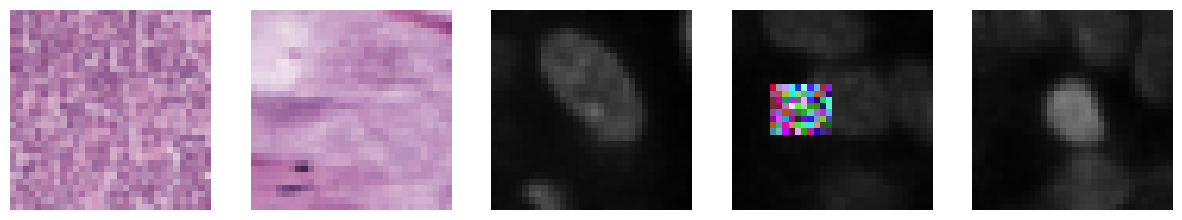

In [ ]:
show_images(data.imgs)

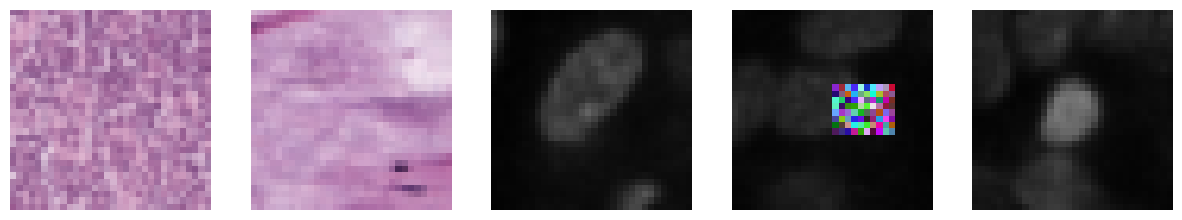

In [ ]:
show_images(horizontal_flip_dataset.imgs)

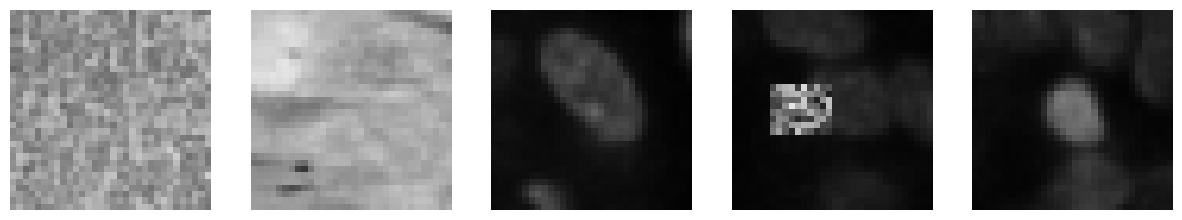

In [ ]:
show_images(grayscale_dataset.imgs)

We requested the API and got the seed 1661712, which gives us the best results

In [ ]:
### REQUESTING NEW API ###
TOKEN = "92593601"

response = requests.get("http://34.71.138.79:9090" + "/stealing_launch", headers={"token": TOKEN})
answer = response.json()

print(answer)
if 'detail' in answer:
    sys.exit(1)

# save the values
SEED = str(answer['seed'])
PORT = str(answer['port'])

# SEED = "1868949"
# PORT = "9002"

{'seed': 1661712, 'port': '9060'}


**Querying the API with the augmented dataset with horizontal flipping.**
- Since the API can be queried with 1000 images at once, we start querying from 0-1000, 1000-2000 ..... 12000-13000. Since we're given the limit of 100 queries per API, we query the same set of images 7 times to the encoder, such that for 13 such sets of 1000 images (training data length is 13000), we get around 91 meaningful representation files.We query the same set of 1000 images 7 times, because we observe that the representations returned by the victim encoder are different even when same image is queried again. We believe that, this is because of the B4B defense used to protect the victim encoder. Please find the detailed reasoning for this in the README.md file added to the repository.

In [ ]:
# obtaining a set of 1000 images from the augmented dataset 1
to_pil = ToPILImage()
pil_images = [to_pil(img_tensor) for img_tensor in horizontal_flip_dataset.imgs]
selected_pil_images = pil_images[0:1000]

We query the above block to obtain the set of 1000 images. Then, we execute the block below to obtain the representation file and store it. For this set of images, we execute the following block 7 times to obtain different representation files for the same set of images. After that, we again execute the block above to get a new set of 1000 images and repeat the same steps as mentioned.

In [ ]:
### QUERYING THE API ###

def model_stealing(images, port):
    endpoint = "/query"
    url = f"http://34.71.138.79:{port}" + endpoint
    image_data = []
    for img in images:
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr.seek(0)
        img_base64 = base64.b64encode(img_byte_arr.getvalue()).decode('utf-8')
        image_data.append(img_base64)

    payload = json.dumps(image_data)
    response = requests.get(url, files={"file": payload}, headers={"token": "92593601"})
    if response.status_code == 200:
        representation = response.json()["representations"]
        return representation
    else:
        raise Exception(
            f"Model stealing failed. Code: {response.status_code}, content: {response.json()}"
        )

out = model_stealing(selected_pil_images, port="9060")

After executing the block below, we observe that the representations returned for the same set of images are different every time because the B4B defense applies different transformations to the actual representations of images and then sends it back to us.

In [ ]:
# 1000 representations in a list
print(len(out))

# representation 1
print(len(out[0]))

# first element in the representation
print(out[0][0], out[0][1])

1000
1024
10463.9375 -6603.1865234375


We store all the representation files separately by executing the following block

In [ ]:
# Store the output in a file.
with open('exp8_5.pickle', 'wb') as handle:
    pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Restore the output from the file.
with open('exp8_5.pickle', 'rb') as handle:
    out = pickle.load(handle)

print(len(out))

1000


To get closer to the actual representations, we try averaging all the 7 representations obtained for an image and store them. For an example, in the block below, we take set 8 covering images 7000-8000 in the dataset, get the following representations from the above blocks and then use them all here to find an averaged representation for this set and similarly for other 12 sets.

In [ ]:
file_paths = ["/content/exp8_1.pickle", "/content/exp8_2.pickle", "/content/exp8_3.pickle",
              "/content/exp8_4.pickle", "/content/exp8_5.pickle", "/content/exp8_6.pickle",
              "/content/exp8_7.pickle"]

all_representations_8 = []

for file_path in file_paths:
    with open(file_path, 'rb') as f:
        representations = pickle.load(f)
        all_representations_8.append(representations)

all_representations = np.array(all_representations_8)

# Calculate the average representation across all the 7 queries
average_representations = np.mean(all_representations, axis=0)
print(len(average_representations))
print(len(average_representations[0]))
print(average_representations[0])

# Store the average representation
with open('average_representations_8.pickle', 'wb') as f:
    pickle.dump(average_representations, f)

1000
1024
[   835.28929029   -653.25876508  -1898.42248099 ...   3078.98181588
  -4348.10183825 -13824.10092163]


We now combine all the averaged representation files obtained for every set of 1000 images (13 such sets) and store it

In [ ]:
victim_representations = []

for i in range(1, 14):
    with open(f'/content/average_representations_{i}.pickle', 'rb') as handle:
        victim_representations.extend(pickle.load(handle))

We store the file combined_all_representations.pickle with all representations of 13000 images. This file can be accessed using the drive link provided.

In [ ]:
with open('combined_all_representations.pickle', 'wb') as handle:
    pickle.dump(victim_representations, handle, protocol=pickle.HIGHEST_PROTOCOL)

Defining the stolen model's architecture and an instance of the Stolen Encoder

In [ ]:
class StolenEncoder(nn.Module):
    def __init__(self, input_channels, input_height, input_width):
        super(StolenEncoder, self).__init__()
        self.input_channels = input_channels
        self.input_height = input_height
        self.input_width = input_width

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128 * (input_height // 4) * (input_width // 4), 1024)
        )

    def forward(self, x):
        return self.encoder(x)

In [55]:
input_channels = 3
input_height = 32
input_width = 32

model = StolenEncoder(input_channels, input_height, input_width).to(device)

In [ ]:
victim_representations = torch.tensor(victim_representations).to(device)

In [ ]:
# converting images from augmented set 2 (grayscale) to PIL format to make them compatible for training the stolen encoder

to_pil = ToPILImage()

def convert_to_pil(grayscale_image_tensors):
    return [to_pil(img) for img in grayscale_image_tensors]

grayscale_image_tensors = [grayscale_dataset.imgs[idx] for idx in range(len(grayscale_dataset))]
grayscale_dataset.imgs = convert_to_pil(grayscale_image_tensors)

**Training the stolen encoder and minimizing the loss between stolen and victim encoder's representations**.
- In the block below, **shuffle** is set to **False** to ensure that the mapping of victim and stolen encoder's representations remains intact.

In [ ]:
flip_data_loader = DataLoader(horizontal_flip_dataset, batch_size=64, shuffle=False)
grayscale_data_loader = DataLoader(grayscale_dataset, batch_size=64, shuffle=False)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 30
for epoch in range(epochs):
    for i, (batch_ids, batch_images, batch_labels) in enumerate(grayscale_data_loader):
        batch_images = [(img.repeat(3, 1, 1) if img.size(0) == 1 else img) for img in batch_images]
        batch_images = torch.stack(batch_images).to(device)

        batch_size = batch_images.size(0)
        start_idx = i * grayscale_data_loader.batch_size
        end_idx = start_idx + batch_size

        if i + 1 > 62:
            continue

        batch_victim_reps = batch_victim_reps.float().to(device)

        stolen_reps = model(batch_images)
        loss = criterion(stolen_reps, batch_victim_reps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}], Loss: {loss.item():.4f}")

torch.save(model, 'stolen_encoder.pth')

In [ ]:
#### SUBMISSION ####

# exporting the stolen encoder to the onnx format

path = '/content/dummy_submission4.onnx'

torch.onnx.export(
    model,
    torch.randn(1, 3, 32, 32).to(device),
    path,
    export_params=True,
    input_names=["x"],
)

#### Tests ####

# (these are being ran on the eval endpoint for every submission)
with open(path, "rb") as f:
    model = f.read()
    try:
        stolen_model = ort.InferenceSession(model)
    except Exception as e:
        raise Exception(f"Invalid model, {e=}")
    try:
        out = stolen_model.run(
            None, {"x": np.random.randn(1, 3, 32, 32).astype(np.float32)}
        )[0][0]
    except Exception as e:
        raise Exception(f"Some issue with the input, {e=}")
    assert out.shape == (1024,), "Invalid output shape"

# Send the model to the server
response = requests.post("http://34.71.138.79:9090/stealing", files={"file": open(path, "rb")}, headers={"token": "92593601", "seed": "1661712"})
print(response.json())